In [235]:
import os
import sys
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import cohen_kappa_score, confusion_matrix,ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, Normalizer

In [236]:
# Put theme of notebook 
from colorama import Fore, Style

# Colors
red = Fore.RED + Style.BRIGHT
mgta = Fore.MAGENTA + Style.BRIGHT
yllw = Fore.YELLOW + Style.BRIGHT
cyn = Fore.CYAN + Style.BRIGHT
blue = Fore.BLUE + Style.BRIGHT

# Reset
res = Style.RESET_ALL

In [237]:
PATH = "/kaggle/input/playground-series-s3e6"
ORIGINAL_DATASET = "/kaggle/input/paris-housing-price-prediction/ParisHousing.csv"

TEST_FILENAME = "test.csv"
TRAIN_FILENAME = "train.csv"
SAMPLE_SUBMISSION_FILENAME = "sample_submission.csv"

TRAIN_DIR = os.path.join(PATH, TRAIN_FILENAME)
TEST_DIR = os.path.join(PATH, TEST_FILENAME)
SAMPLE_SUBMISSION_DIR = os.path.join(PATH, SAMPLE_SUBMISSION_FILENAME)


# Values
SQUERE_METERS = "squareMeters"
NUMBER_ROOMS = "numberOfRooms"
HAS_YARD = "hasYard"
HAS_POOL = "hasPool"
FLOORS = "floors"
CITY_CODE = "cityCode"
CITY_PART_RANGE = "cityPartRange"
NUM_PREV_OWNERS = "numPrevOwners"
MADE = "made"
IS_NEW_BUILT = "isNewBuilt"
HAS_STORM_PROTECTOR = "hasStormProtector"
BASMENT = "basement"
ATTIC = "attic"
GARAGE = "garage"
HAS_STORAGE_ROOM = "hasStorageRoom"
HAS_GUESS_ROOM = "hasGuestRoom"
TARGET = "price"
ID = "id"

# Colors
CREME_CYAN = "#93adad"
MAGENTA = "#f78dad"
DARK_BLUE = "#8084bd"
CREME = "#DEB078"
PINK = "#e28ee8"
ORANGE = "#e8a18e"
YELLOW = "#e8e78e"
PURLPLE = "#bb8ee8"
COLORS = [CREME_CYAN, MAGENTA, DARK_BLUE, CREME, PINK, ORANGE, YELLOW, PURLPLE]
print(TEST_DIR)

/kaggle/input/playground-series-s3e6/test.csv


In [238]:
CATEGORICAL_COLS = [HAS_YARD, HAS_POOL,HAS_STORM_PROTECTOR, 
                    HAS_STORAGE_ROOM, HAS_GUESS_ROOM, IS_NEW_BUILT,
                    CITY_CODE, CITY_PART_RANGE]

NUM_COLS = [SQUERE_METERS, NUMBER_ROOMS, FLOORS,
            NUM_PREV_OWNERS, BASMENT, ATTIC, GARAGE]

FEATURE_COLS = CATEGORICAL_COLS + NUM_COLS

In [239]:
def data_description(df):
    print("Data description")
    print(f"Total number of records {df.shape[0]}")
    print(f'number of features {df.shape[1]}\n\n')
    columns = df.columns
    data_type = []
    
    # Get the datatype of features
    for col in df.columns:
        data_type.append(df[col].dtype)
        
    n_uni = df.nunique()
    # Number of NaN values
    n_miss = df.isna().sum()
    
    names = list(zip(columns, data_type, n_uni, n_miss))
    variable_desc = pd.DataFrame(names, columns=["Name","Type","Unique levels","Missing"])
    print(variable_desc)


In [240]:
def show_corr_heatmap(df, title):
    
    corr = df.corr()
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True

    plt.figure(figsize = (15, 10))
    plt.title(title)
    sns.heatmap(corr, annot = True, linewidths=.5, fmt=".2f", square=True, mask = mask)
    plt.show()

In [241]:
train_df = pd.read_csv(TRAIN_DIR, dtype={CITY_CODE: object})
test_df = pd.read_csv(TEST_DIR, dtype={CITY_CODE: object})
original_df = pd.read_csv(ORIGINAL_DATASET, dtype={CITY_CODE: object})
original_df = original_df.reset_index()
original_df[ID] = original_df["index"] + 1000000
original_df = original_df.drop(columns = ["index"])
train_df.head()

,id,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
0,0,34291,24,1,0,47,35693,2,1,2000,0,1,8,5196,369,0,3,3436795.2
1,1,95145,60,0,1,60,34773,1,4,2000,0,1,729,4496,277,0,6,9519958.0
2,2,92661,45,1,1,62,45457,4,8,2020,1,1,7473,8953,245,1,9,9276448.1
3,3,97184,99,0,0,59,15113,1,1,2000,0,1,6424,8522,256,1,9,9725732.2
4,4,61752,100,0,0,57,64245,8,4,2018,1,0,7151,2786,863,0,7,6181908.8


In [242]:
original_df.head()

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price,id
0,75523,3,0,1,63,9373,3,8,2005,0,1,4313,9005,956,0,7,7559081.5,1000000
1,80771,39,1,1,98,39381,8,6,2015,1,0,3653,2436,128,1,2,8085989.5,1000001
2,55712,58,0,1,19,34457,6,8,2021,0,0,2937,8852,135,1,9,5574642.1,1000002
3,32316,47,0,0,6,27939,10,4,2012,0,1,659,7141,359,0,3,3232561.2,1000003
4,70429,19,1,1,90,38045,3,7,1990,1,0,8435,2429,292,1,4,7055052.0,1000004


In [243]:
train_df[CITY_CODE] = train_df[CITY_CODE].str.zfill(5)
test_df[CITY_CODE] = train_df[CITY_CODE].str.zfill(5)
original_df[CITY_CODE] = train_df[CITY_CODE].str.zfill(5)

In [244]:
print(f"Train dataframe length: {mgta}{len(train_df)}{res}\tTest dataframe length: {mgta}{len(test_df)}{res}\tOriginal dataframea length: {mgta}{len(original_df)}{res}")

Train dataframe length: 22730	Test dataframe length: 15154	Original dataframea length: 10000


In [245]:
num_cols = train_df.select_dtypes(include=np.number).columns.tolist()
num_cols.remove(ID)
num_cols.remove(TARGET)

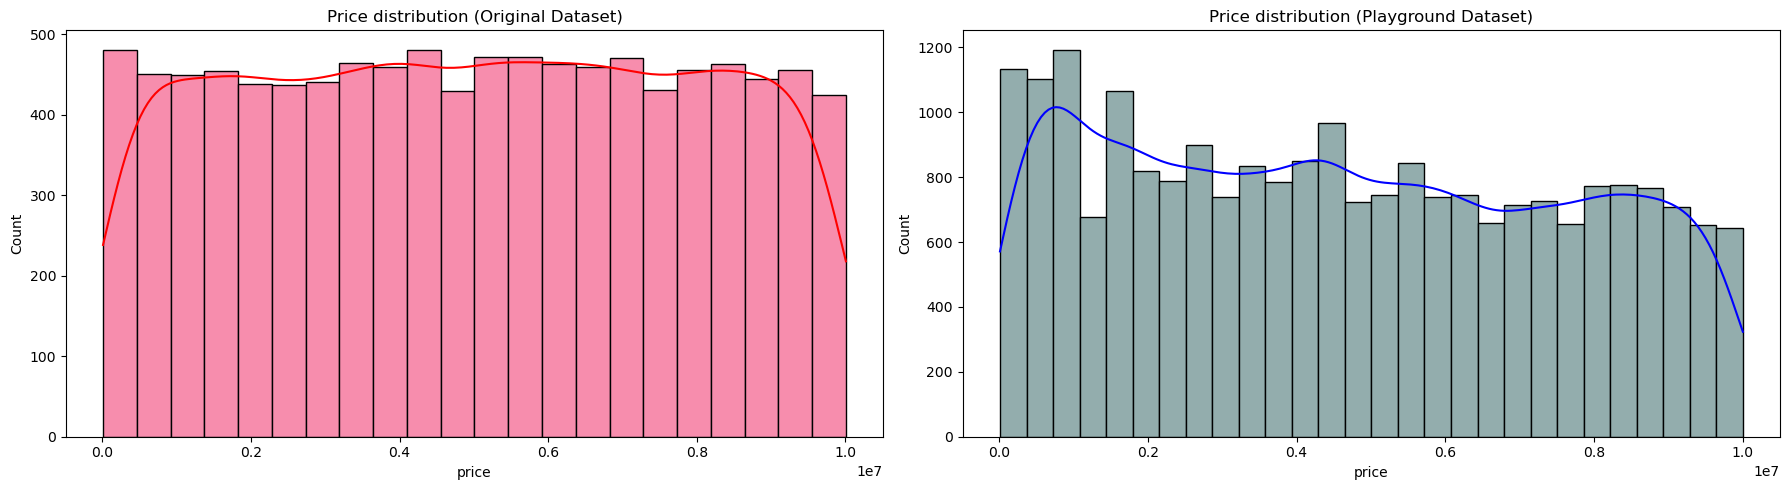

In [246]:
fig, ax = plt.subplots(1, 2, figsize=(18, 5))

sns.histplot(original_df[TARGET], color="red", ax=ax[0], kde=True)
ax[0].set_title("Price distribution (Original Dataset)", fontsize=12)
for patch in ax[0].patches:
    patch.set_fc(MAGENTA)
    
sns.histplot(train_df[TARGET], color="blue", ax=ax[1], kde=True)
ax[1].set_title("Price distribution (Playground Dataset)", fontsize=12)
for patch in ax[1].patches:
    patch.set_fc(CREME_CYAN)
    
plt.tight_layout()
plt.show()

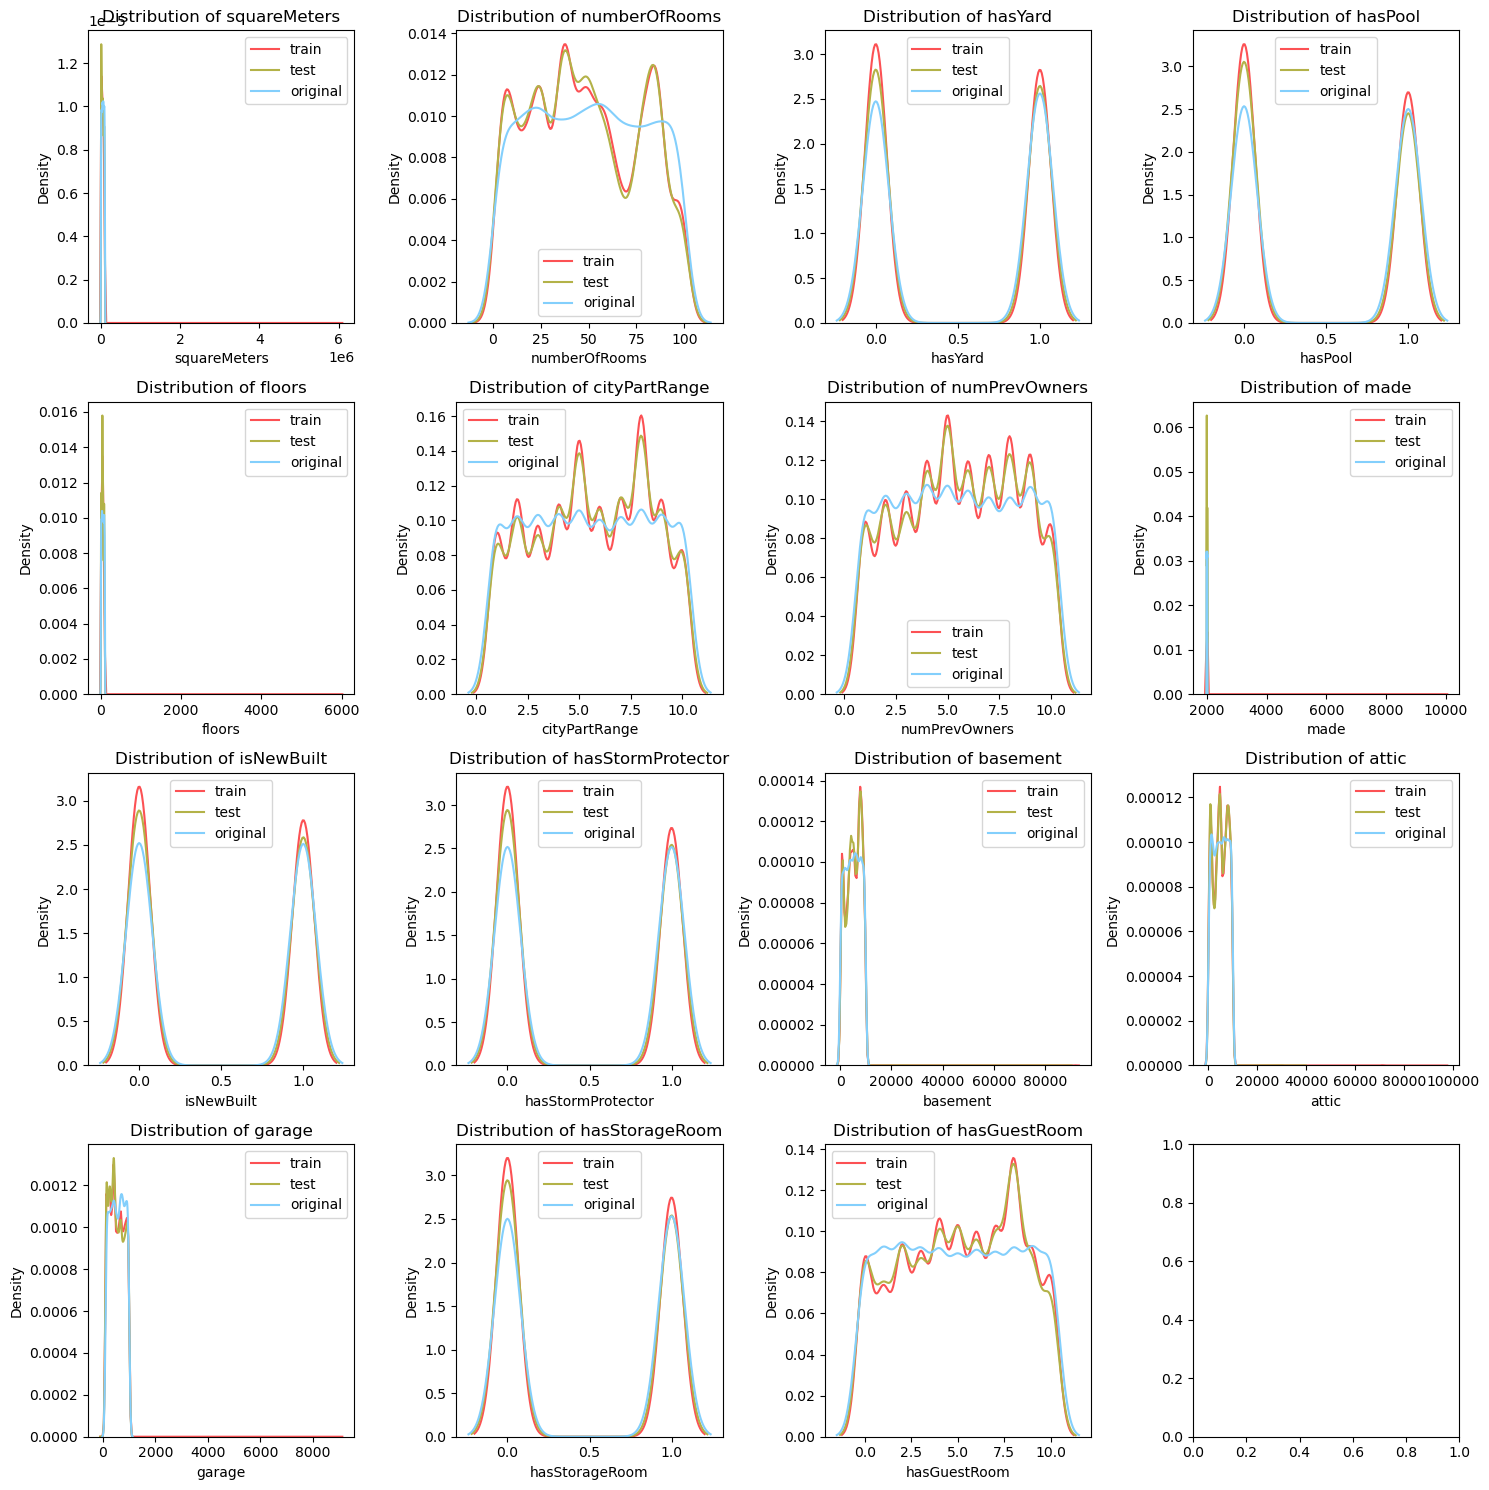

In [247]:
ncols = 4
nrows = int(np.ceil(len(num_cols)/ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15))
for ax, x in zip(axes.flat, num_cols):
    sns.kdeplot(train_df[x], color="#FC5154", label="train", ax=ax)
    sns.kdeplot(test_df[x], color="#B3B248", label="test", ax=ax)
    sns.kdeplot(original_df[x], color="#83CFFC", label="original", ax=ax)
    ax.set_title(f"Distribution of {x}")
    ax.legend()
plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='set', ylabel='garage'>

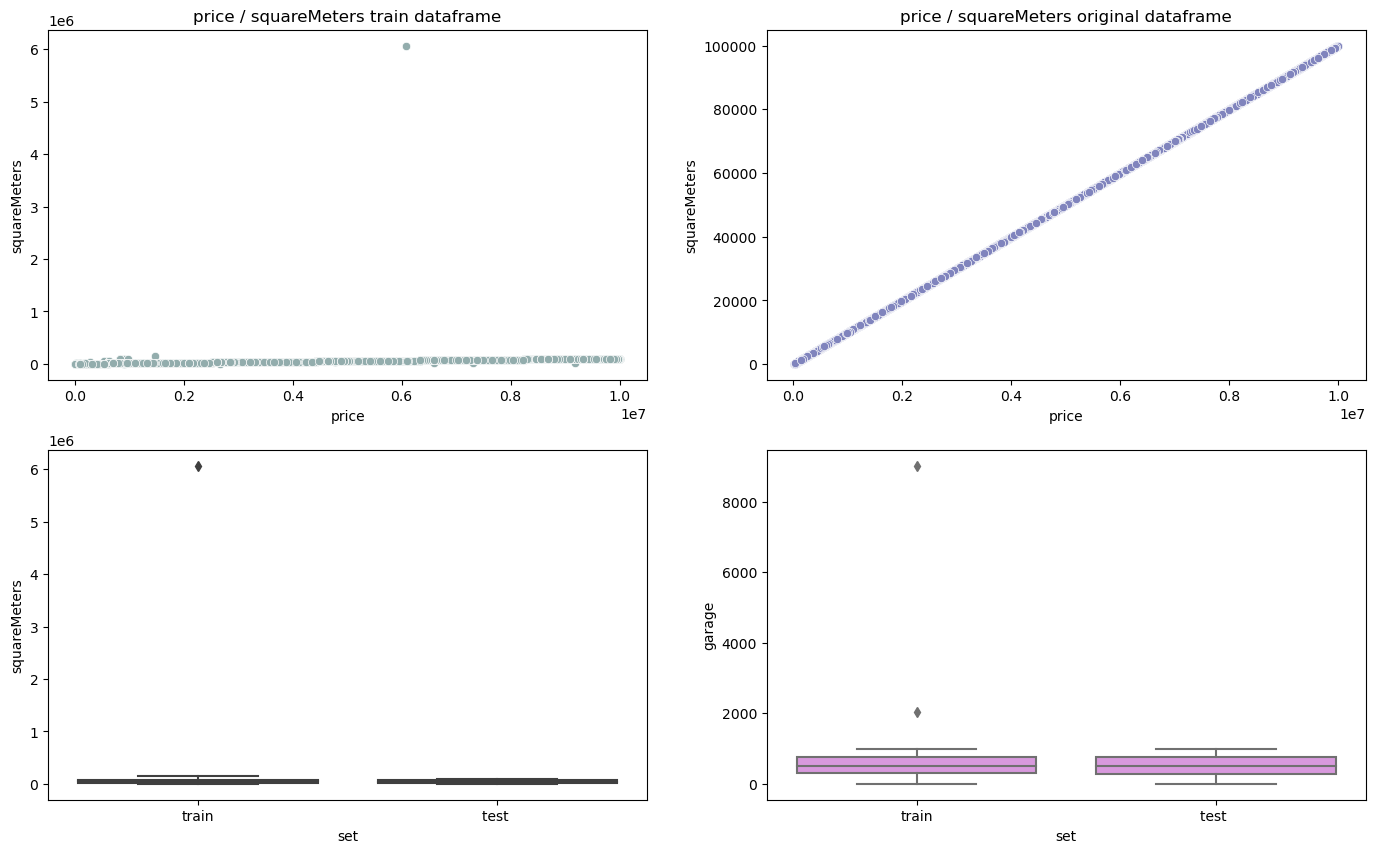

In [248]:
total_df = pd.concat([train_df, test_df], axis=0)
total_df['set'] = 'test '
total_df.iloc[:train_df.shape[0], -1] = 'train'

fig, ax = plt.subplots(2, 2, figsize=(17, 10))

sns.scatterplot(ax=ax[0,0], data=train_df, x=TARGET,y=SQUERE_METERS, color=CREME_CYAN)
ax[0, 0].set_title(f"{TARGET} / {SQUERE_METERS} train dataframe")
sns.scatterplot(ax=ax[0,1], data=original_df, x=TARGET,y=SQUERE_METERS, color=DARK_BLUE)
ax[0, 1].set_title(f"{TARGET} / {SQUERE_METERS} original dataframe")
sns.boxplot(y=total_df[SQUERE_METERS], x=total_df['set'], ax=ax[1][0])
sns.boxplot(y=total_df[GARAGE], x=total_df['set'], ax=ax[1][1], color=PINK)

<AxesSubplot:ylabel='price'>

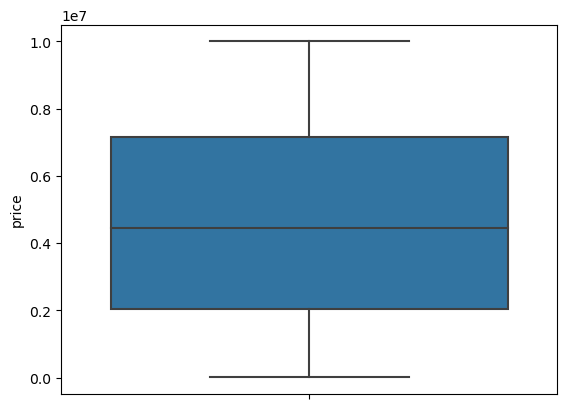

In [249]:
sns.boxplot(y = TARGET, data = train_df)

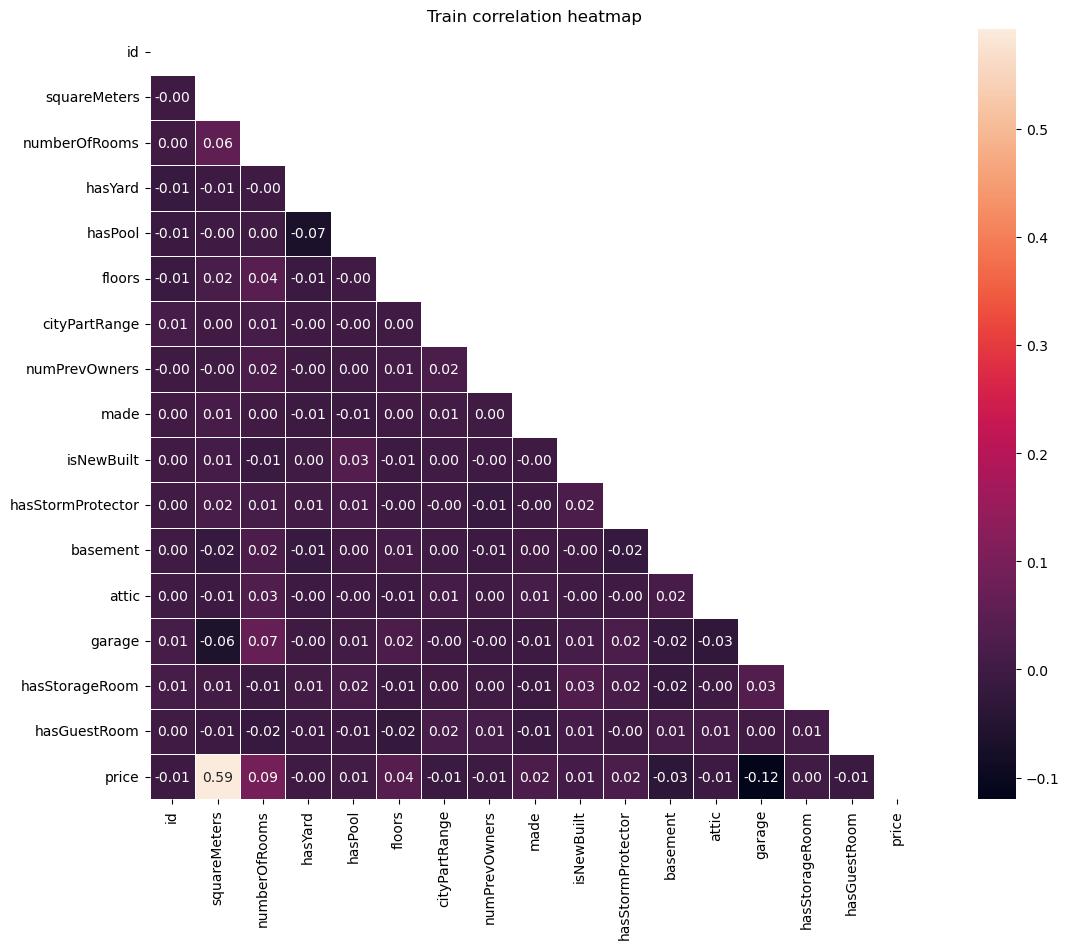

None

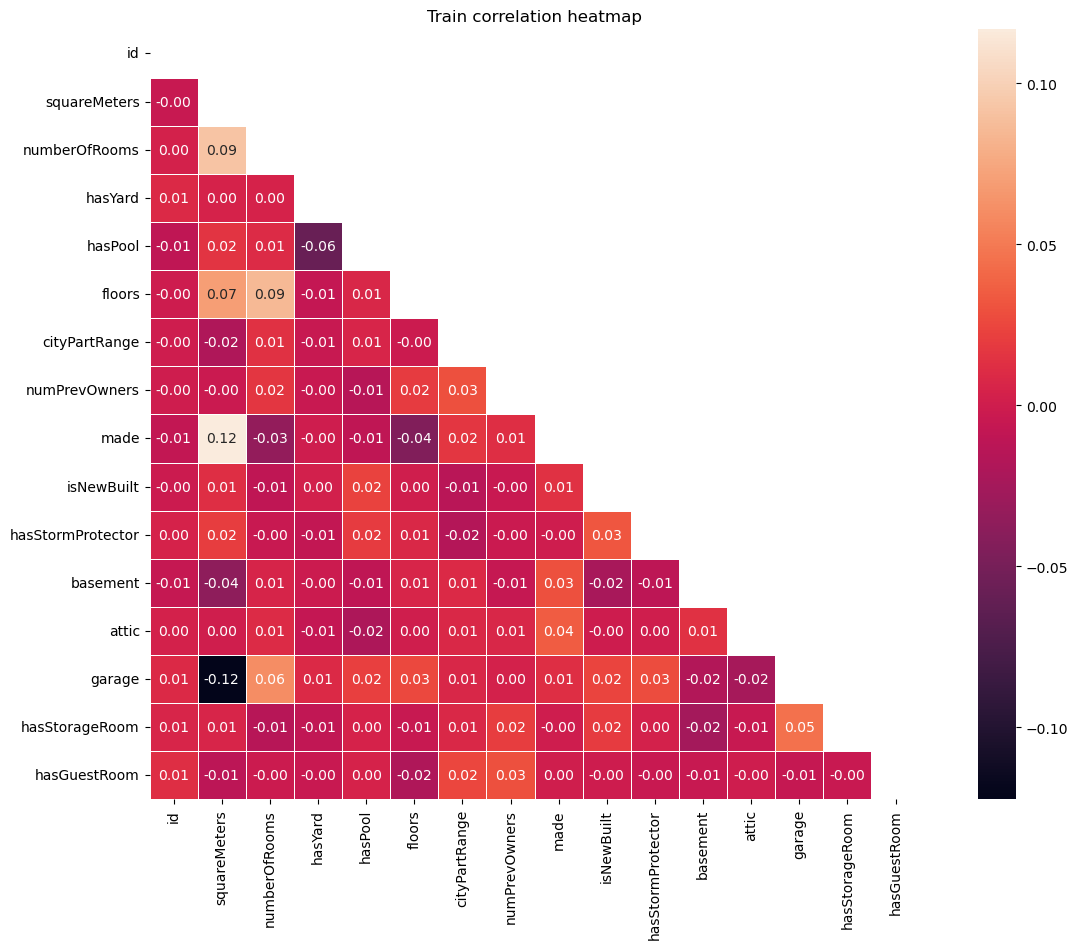

None

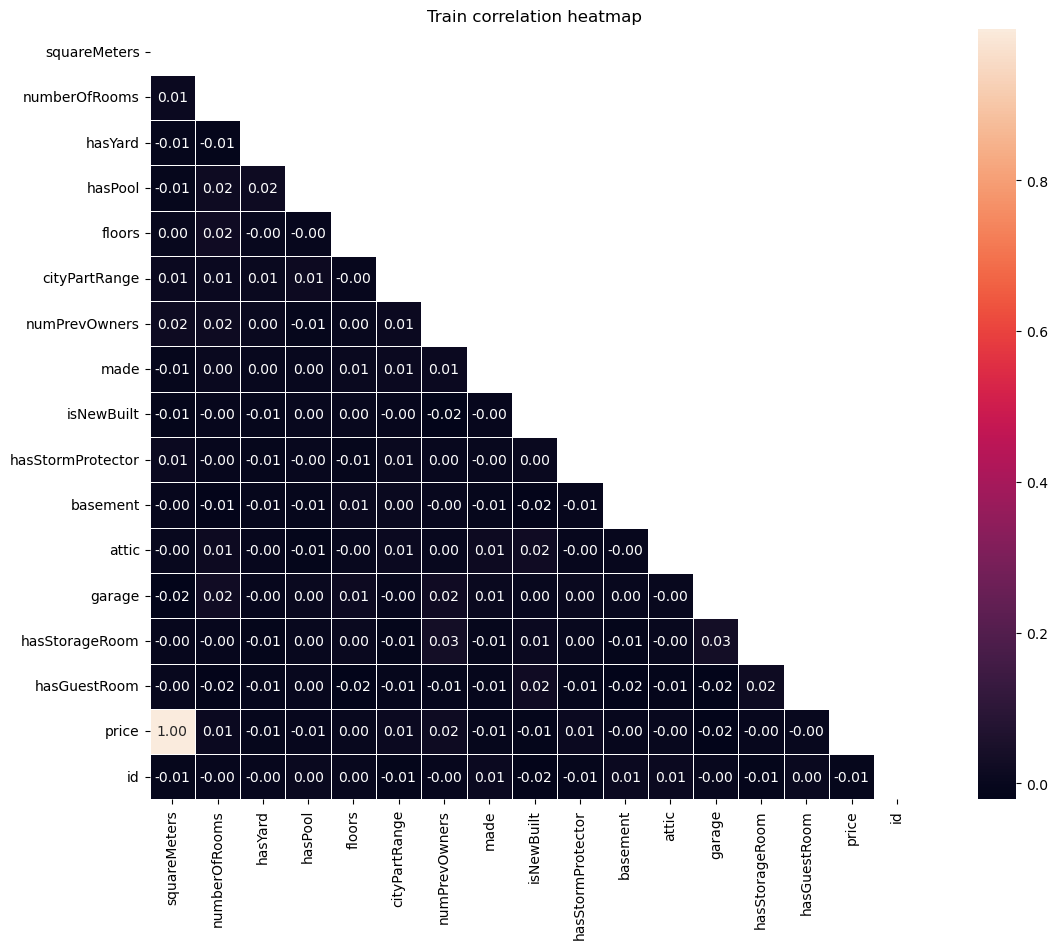

None

In [250]:
display(show_corr_heatmap(train_df, "Train correlation heatmap"))
display(show_corr_heatmap(test_df, "Train correlation heatmap"))
display(show_corr_heatmap(original_df, "Train correlation heatmap"))

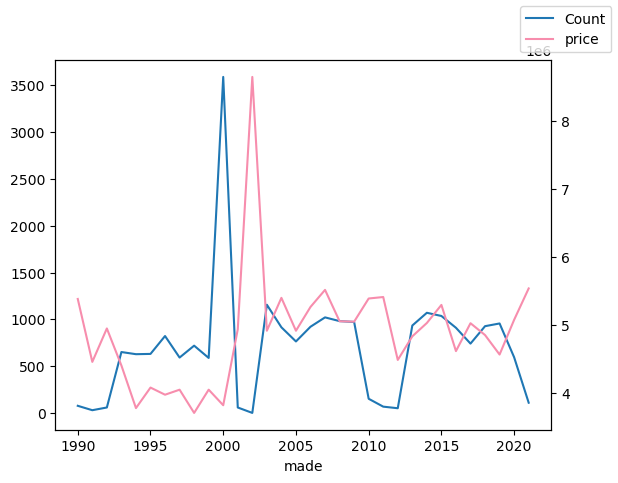

In [251]:
made = pd.DataFrame(train_df.groupby([MADE]).size()).reset_index().rename(columns = {0:"Count"})
made = made[made[MADE]< 5000]

made1 = pd.DataFrame(train_df.groupby([MADE])[TARGET].mean()).reset_index().rename(columns = {0:"mean_price"})

made = pd.merge(made,made1, on = MADE, how = "inner")

ax = made.plot(x=MADE, y="Count", legend=False)
ax2 = ax.twinx()
made.plot(x=MADE, y=TARGET, ax=ax2, legend=False, color=MAGENTA)
ax.figure.legend()
plt.show()

In [252]:
made[made[MADE]<= 2000].corr()

,made,Count,price
made,1.000000,0.672256,-0.790501
Count,0.672256,1.000000,-0.486776
price,-0.790501,-0.486776,1.000000


In [253]:
made[made[MADE]> 2007].corr()

,made,Count,price
made,1.000000,0.025725,-0.069582
Count,0.025725,1.000000,-0.346971
price,-0.069582,-0.346971,1.000000


In [254]:
train_df = pd.concat([train_df, original_df])

In [255]:
train_1 = train_df[train_df[MADE]<=2000]
test_1 = test_df[test_df[MADE]<=2000]
train_2 = train_df[(train_df[MADE]>=2001) & (train_df[MADE]<=2007)]
test_2 = test_df[(test_df[MADE]>=2001) & (test_df[MADE]<=2007)]
train_3 = train_df[train_df[MADE]>2007]
test_3 = test_df[test_df[MADE]>2007]

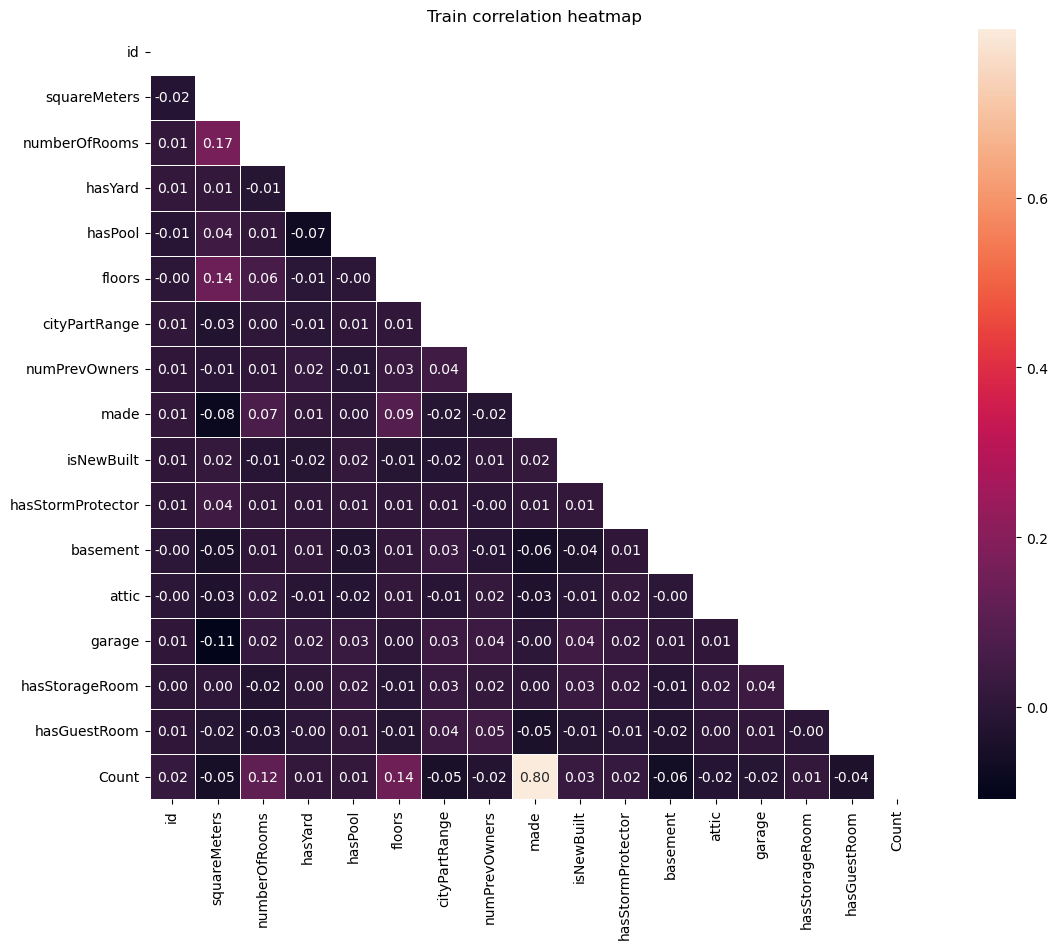

None

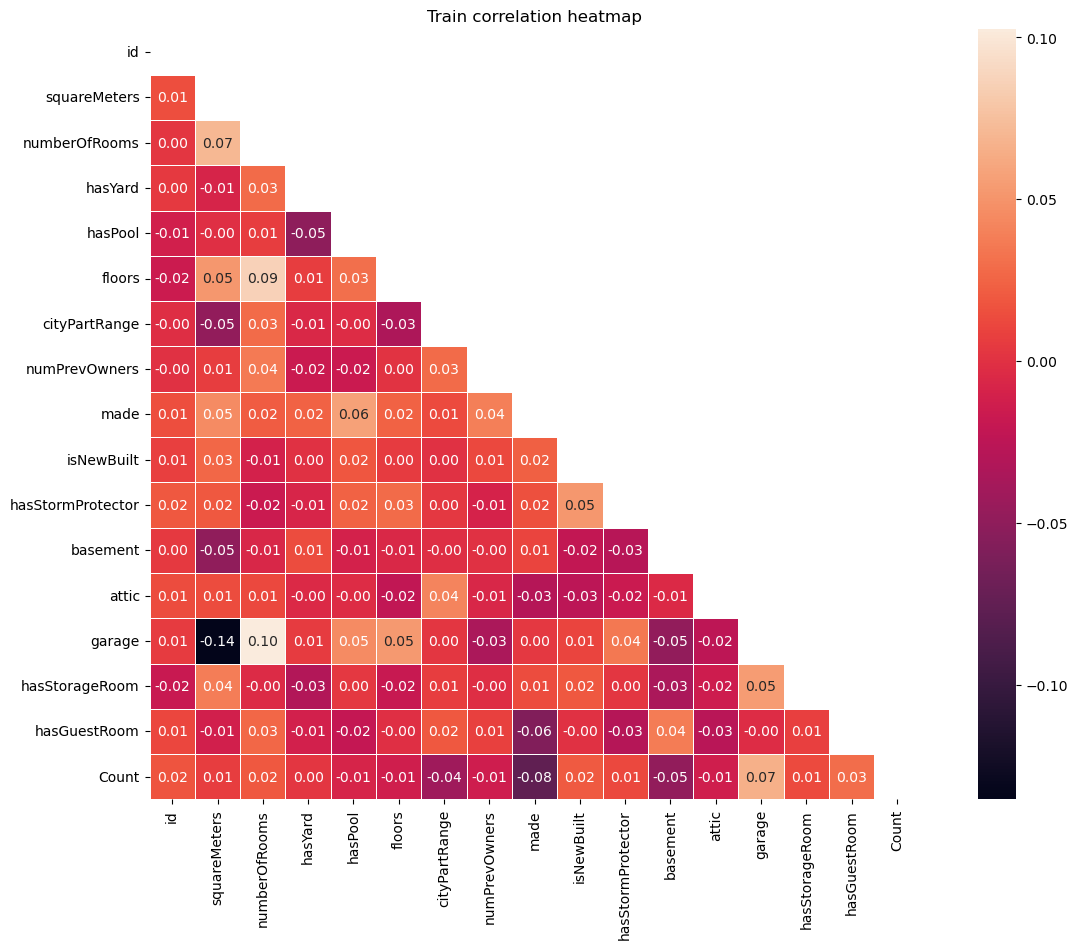

None

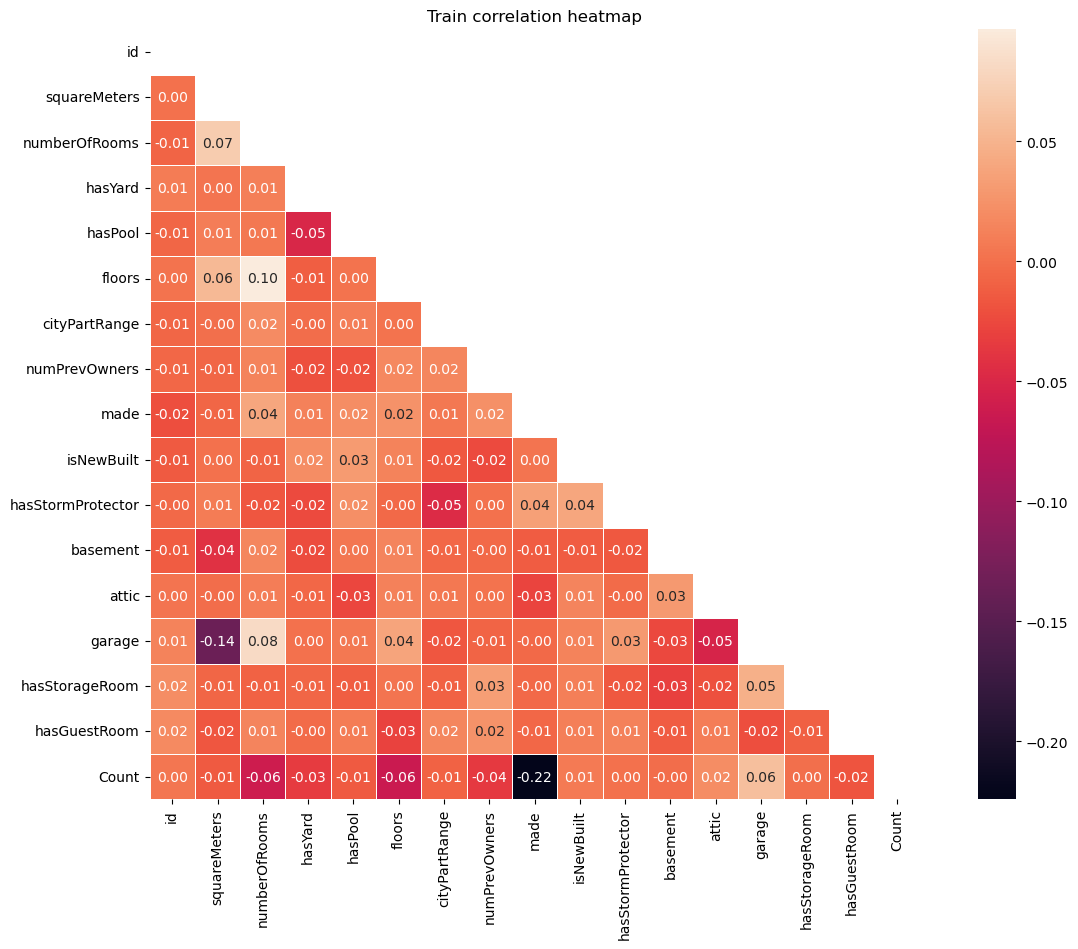

None

In [256]:
train_1 = pd.merge(train_1,made[[MADE,'Count']], on = MADE, how = 'inner')
test_1 = pd.merge(test_1,made[[MADE,'Count']], on = MADE, how = 'inner')
display(show_corr_heatmap(test_1, "Test_1 correlation heatmap"))
train_2 = pd.merge(train_2,made[[MADE,'Count']], on = MADE, how = 'inner')
test_2 = pd.merge(test_2,made[[MADE,'Count']], on = MADE, how = 'inner')
display(show_corr_heatmap(test_2, "Test_2 correlation heatmap"))
train_3 = pd.merge(train_3,made[[MADE,'Count']], on = MADE, how = 'inner')
test_3 = pd.merge(test_3,made[[MADE,'Count']], on = MADE, how = 'inner')
display(show_corr_heatmap(test_3, "Test_3 correlation heatmap"))


In [257]:
num_cols = num_cols + ["Count"]

In [ ]:
LR = 0.20
NE = 3500

In [258]:
X1 = train_1[num_cols]
# X1 = train_1[['squareMeters']]
y1 = train_1[TARGET]

model=XGBRegressor(max_depth=3, learning_rate=LR , n_estimators=NE, objective="reg:linear", booster="gbtree")
XGB=model.fit(X1,y1)


X_test = test_1[num_cols]
# X_test = test_1[['squareMeters']]
prediction=XGB.predict(X_test)

test_1[TARGET] = prediction
test_1

[12:51:38] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


,id,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,Count,price
0,22730,47580,89,0,1,8,35693,5,3,1995,0,0,6885,8181,241,0,8,631,4758011.000
1,22751,69856,47,0,1,26,77004,1,8,1995,1,0,17,853,854,1,8,631,6995771.000
2,22755,23608,51,0,0,31,84602,10,6,1995,1,0,6410,8153,945,1,8,631,2364168.250
3,22775,67724,11,1,1,64,51336,2,10,1995,0,1,7448,1932,128,1,2,631,6778856.500
4,22815,50778,39,0,1,94,49199,2,1,1995,0,0,5294,7178,614,0,2,631,5074851.500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5584,35303,84696,45,0,0,14,24522,7,4,1991,0,1,8681,5246,524,1,6,30,8468765.000
5585,35522,42630,34,0,1,25,37363,9,7,1991,1,0,7976,331,236,0,0,30,4239987.000
5586,35686,18316,20,0,1,5,28086,2,6,1991,0,0,6574,2166,127,1,5,30,1847247.375
5587,36267,41700,48,0,1,8,84704,5,7,1991,0,0,743,7716,194,1,2,30,4206274.500


In [259]:
X2 = train_2[num_cols]
# X2 = train_2[['squareMeters']]
y2 = train_2[TARGET]

model=XGBRegressor(max_depth=3, learning_rate=LR , n_estimators=NE, objective="reg:linear", booster="gbtree")
XGB=model.fit(X2,y2)

X_test = test_2[num_cols]
# X_test = test_2[['squareMeters']]
prediction=XGB.predict(X_test)

test_2[TARGET] = prediction
test_2

[12:51:50] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


,id,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,Count,price
0,22740,69567,38,0,0,11,54900,8,3,2003,0,1,8194,8627,124,0,3,1156,6966366.00
1,22776,15351,34,0,0,10,68109,3,6,2003,0,0,6341,5844,929,1,6,1156,1544070.75
2,22868,4198,6,1,0,80,38929,3,8,2003,0,0,3795,4194,885,1,8,1156,405859.50
3,22887,62064,86,1,1,35,48037,2,3,2003,1,0,8000,2600,976,0,10,1156,6180837.50
4,22907,91618,4,0,0,36,74838,8,3,2003,1,1,6484,2731,121,1,5,1156,9159348.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3225,36015,73748,84,0,0,32,85082,5,2,2001,1,1,4309,7379,273,1,9,59,7383201.50
3226,36030,90170,63,1,1,20,04081,9,5,2001,1,0,4196,2528,945,1,3,59,9012547.00
3227,36156,41700,8,0,0,64,53916,7,9,2001,1,0,8163,8153,194,0,8,59,4174734.75
3228,36298,55620,61,1,1,90,66390,3,4,2001,1,1,9867,7179,548,0,1,59,5568641.50


In [260]:
X3 = train_3[num_cols]
y3 = train_3[TARGET]

model=XGBRegressor(max_depth=3, learning_rate=LR , n_estimators=NE, objective="reg:linear", booster="gbtree")
XGB=model.fit(X3,y3)

X_test = test_3[num_cols]
prediction=XGB.predict(X_test)

test_3[TARGET] = prediction
test_3

[12:52:00] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


,id,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,Count,price
0,22733,16354,47,1,1,9,15113,6,5,2019,1,1,705,5097,122,1,5,956,1644086.750
1,22748,35423,52,1,1,24,72385,6,8,2019,1,0,8486,4375,489,1,5,956,3558887.000
2,22820,85256,74,0,1,39,50147,1,1,2019,0,1,3945,5240,745,1,0,956,8520852.000
3,22826,68847,74,1,1,80,22176,10,6,2019,0,1,9789,9476,847,1,5,956,6885240.000
4,22840,15815,13,1,1,7,22460,7,3,2019,1,1,2494,8575,827,1,5,956,1570423.875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6330,36857,54484,38,1,1,78,52734,8,6,2011,0,1,8235,8136,114,1,8,68,5453139.500
6331,37118,54484,25,1,0,94,46686,4,5,2011,0,1,8163,8889,241,0,6,68,5447892.000
6332,37278,27949,84,1,0,94,98846,5,9,2011,1,1,8578,9248,245,1,1,68,2789866.750
6333,37431,76932,85,0,1,89,16768,5,4,2011,0,0,8767,8149,583,1,0,68,7705767.000


In [261]:
submission = pd.concat([test_1,test_2,test_3])
submission = submission[[ID,TARGET]]
submission = submission.sort_values(by = [ID])
submission.to_csv("submission.csv",index = False)

,id,price
0,22730,4758011.00
402,22731,6219134.00
827,22732,9070699.00
0,22733,1644086.75
685,22734,6751079.00
